In [1]:
!pip install -q seaborn

In [3]:
from __future__ import division, print_function, absolute_import

import pathlib

import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.__version__

'1.12.0'

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path


'/home/rohan/.keras/datasets/auto-mpg.data'

In [9]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names = column_names, na_values='?', comment = '\t', sep = ' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [11]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [12]:
dataset = dataset.dropna()

In [13]:
# The "Origin" column is really categorical,
# not numeric. So convert that to a one-hot:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [14]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

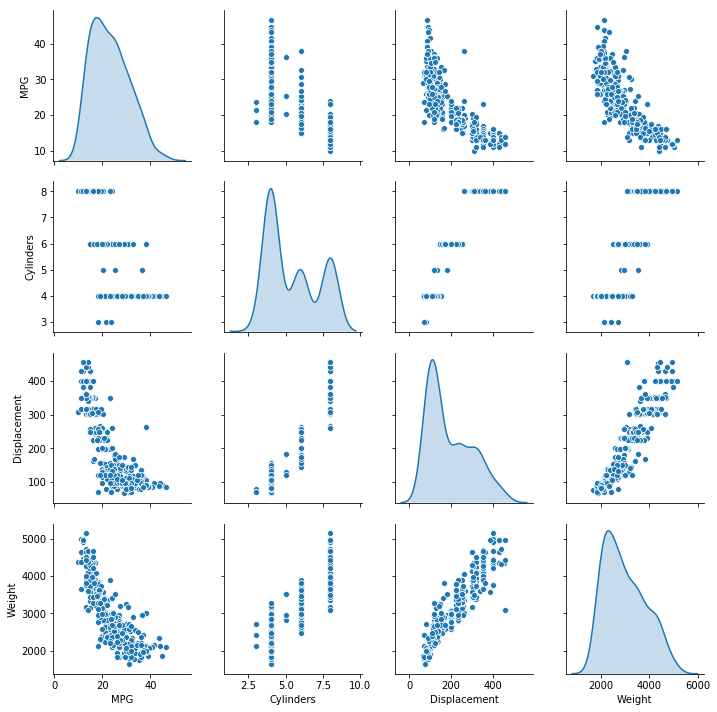

In [15]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [16]:
train_stats = train_dataset.describe()
train_stats

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.624204,0.178344,0.197452
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.485101,0.383413,0.398712
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [17]:
train_stats.pop('MPG')

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [18]:
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [19]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [20]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse', optimizer = optimizer,
                 metrics=['mae', 'mse'])
    
    return model

In [21]:
model = build_model()

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [24]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)

example_result

array([[-0.26211187],
       [-0.30266383],
       [ 0.15324251],
       [-0.15758818],
       [-0.36122212],
       [-0.15574121],
       [-0.3236453 ],
       [-0.5922936 ],
       [-0.2361556 ],
       [-0.3182301 ]], dtype=float32)

In [25]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch%100 == 0: print('')
        print('.', end='')
        
EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs = EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,10.331760,2.392155,10.331760,2.382574,0.964042,2.382574,995
996,10.634082,2.430654,10.634082,2.425509,0.990562,2.425509,996
997,10.298071,2.403936,10.298071,2.446011,0.977420,2.446011,997
998,9.952130,2.362605,9.952130,2.524098,0.989986,2.524098,998
999,10.455579,2.451688,10.455579,2.400957,0.980783,2.400957,999


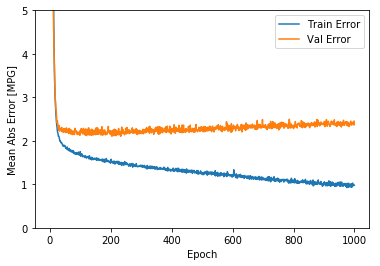

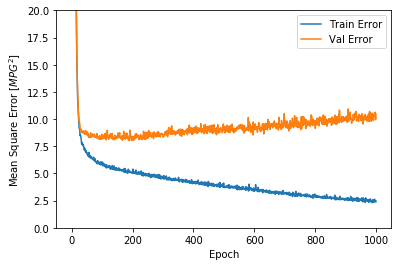

In [27]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,5])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,20])

plot_history(history)



.....................................................

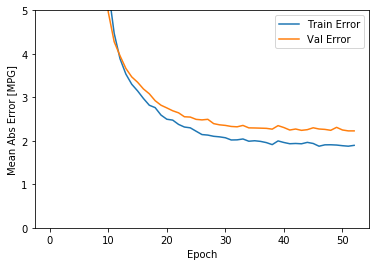

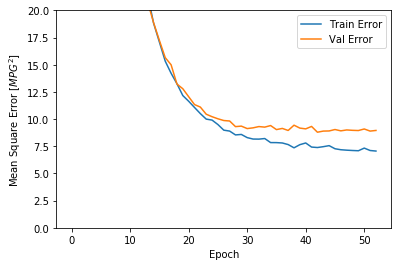

In [28]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
# Early stopping is a useful technique to prevent overfitting.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


In [29]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


Testing set Mean Abs Error:  1.89 MPG
